In [72]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
import numpy as np
from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
from torchvision import transforms
import matplotlib.pyplot as plt

use_cuda=False
last_layer_threshold=50


######################################################
class SNN_Global_max(nn.Module):
    def __init__(self):
        super(SNN_Global_max, self).__init__()
        self.conv1 = snn.Convolution(2, 32, 5, 0.8, 0.05)
        self.conv1_t = 6
        self.k1 = 10
        self.r1 = 2

        self.conv2 = snn.Convolution(32, 150, 5, 0.8, 0.05)
        self.conv2_t = 3
        self.k2 = 100
        self.r2 = 1

        self.conv3 = snn.Convolution(150, 60, 20, 0.8, 0.05)
        self.conv3_t = last_layer_threshold
        self.k3 = 60
        self.r3 = 1 #tune this parameter?
        
        self.stdp1 = snn.STDP(self.conv1, (0.008, -0.001))
        self.stdp2 = snn.STDP(self.conv2, (0.03, -0.001))
        self.stdp3 = snn.STDP(self.conv3, (0.03, -0.001))
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0
        self.spk_cnt3 = 0
    
    def save_data(self, input_spike, potentials, output_spikes, winners):
        self.ctx["input_spikes"] = input_spike
        self.ctx["potentials"] = potentials
        self.ctx["output_spikes"] = output_spikes
        self.ctx["winners"] = winners

    def forward(self, input, max_layer=None):
        input = sf.pad(input.float(), (2,2,2,2),0)
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)

            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.save_data(input, pot, spk, winners)
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 7, 6), (2,2,2,2))
            spk_in = sf.pointwise_inhibition(spk_in)
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)

            if max_layer == 2:
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.save_data(spk_in, pot, spk, winners)
                return spk, pot

            spk_in = sf.pad(sf.pooling(spk, 2, 2), (2,2,2,2))
            spk_in = sf.pointwise_inhibition(spk_in)
            pot = self.conv3(spk_in)
            spk, pot = sf.fire(pot, self.conv3_t, True)   

            if max_layer == 3:
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k3, self.r3, spk)
                self.save_data(spk_in, pot, spk, winners)
                return spk, pot    
            
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            pot = sf.pointwise_inhibition(pot)
            spk = pot.sign()
            spk_1=sf.pooling(spk, 7, 6)
            pot = self.conv2(sf.pad(spk_1, (2,2,2,2)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            pot = sf.pointwise_inhibition(pot)
            spk = pot.sign()
            spk_2 = sf.pooling(spk, 2, 2)
            pot = self.conv3(sf.pad(spk_2, (2,2,2,2)))
            spk_3, pot = sf.fire(pot, self.conv3_t, True)
            pot = sf.pointwise_inhibition(pot)
            spk_3 = pot.sign()
            
            #manual global max pooling 
            spk_3=spk_3.reshape(spk_3.shape[0],spk_3.shape[1],-1)
            spk_3=spk_3.mean(axis=-1).sign()

            return spk_3,spk_2,spk_1
    
    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 3:
            self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])    
            
    ##################################################
    
def train_unsupervise(network, data, layer_idx):
    network.train()
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def test(network, data, target, layer_idx):
    network.eval()
    ans = [None] * len(data)
    t = [None] * len(data)
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        output,_ = network(data_in, layer_idx).max(dim = 0)
        ans[i] = output.reshape(-1).cpu().numpy()
        t[i] = target[i]
    return np.array(ans), np.array(t)



In [ ]:
data=TensorDataset(torch.load("images_gray_final_training.pt"),torch.load("labels_gray_final_training.pt"))

from sklearn.model_selection import train_test_split

train_dataset, test_dataset= train_test_split(data,test_size=0.15, shuffle=True,random_state=42,stratify=torch.load("labels_gray_final_training.pt"))

train_dataset=utils.CacheDataset(train_dataset)
test_dataset=utils.CacheDataset(test_dataset)


train_data=[train_dataset[i][0] for i in range(len(train_dataset))]
test_data=[test_dataset[i][0] for i in range(len(test_dataset))]

In [73]:

global_max_snn_model = SNN_Global_max()

if use_cuda:
    global_max_snn_model.cuda()

global_max_snn_model.load_state_dict(torch.load(r"C:\Users\USER\Desktop\Kheradpisheh_ETH\final_data_subjects\saved_l3_global_max_final_threshold100.net",
                                                map_location=torch.device('cpu')))

global_max_snn_model.eval()

SNN_Global_max(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
)

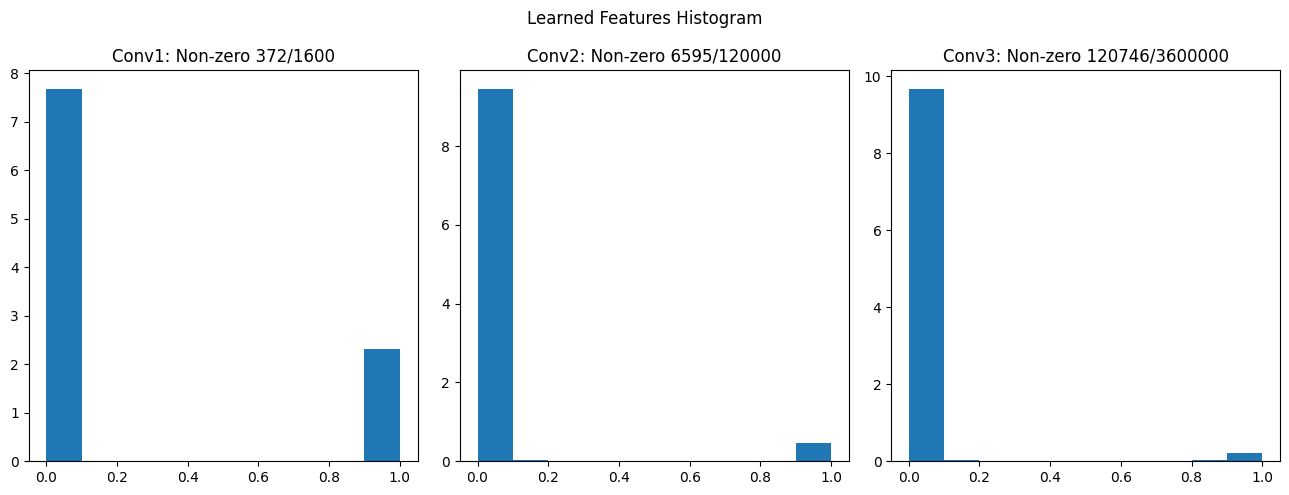

last layer's Convergence index= 0.0076


In [14]:
#weights histogram

#convergence index definition

def convergence_index(conv_weights):

    return np.mean(conv_weights.reshape(-1)*(1-conv_weights.reshape(-1)))

w1_array=global_max_snn_model.conv1._parameters["weight"].cpu().numpy()
w2_array=global_max_snn_model.conv2._parameters["weight"].cpu().numpy()
w3_array=global_max_snn_model.conv3._parameters["weight"].cpu().numpy()


plt.figure(figsize=(13,5))
plt.suptitle("Learned Features Histogram",fontsize=12)
plt.subplot(1,3,1)
plt.hist(w1_array.reshape(-1),density=True)
plt.title(f"Conv1: Non-zero {len(w1_array.reshape(-1)[w1_array.reshape(-1)>0.1])}/{len(w1_array.reshape(-1))}")

plt.subplot(1,3,2)
plt.hist(w2_array.reshape(-1),density=True)
plt.title(f"Conv2: Non-zero {len(w2_array.reshape(-1)[w2_array.reshape(-1)>0.1])}/{len(w2_array.reshape(-1))}")

plt.subplot(1,3,3)
plt.hist(w3_array.reshape(-1),density=True)
plt.title(f"Conv3: Non-zero {len(w3_array.reshape(-1)[w3_array.reshape(-1)>0.1])}/{len(w3_array.reshape(-1))}")


#plt.savefig("hist_learned_weights")
plt.tight_layout()
plt.show()

print(f"last layer's Convergence index= {convergence_index(w3_array):.4f}")

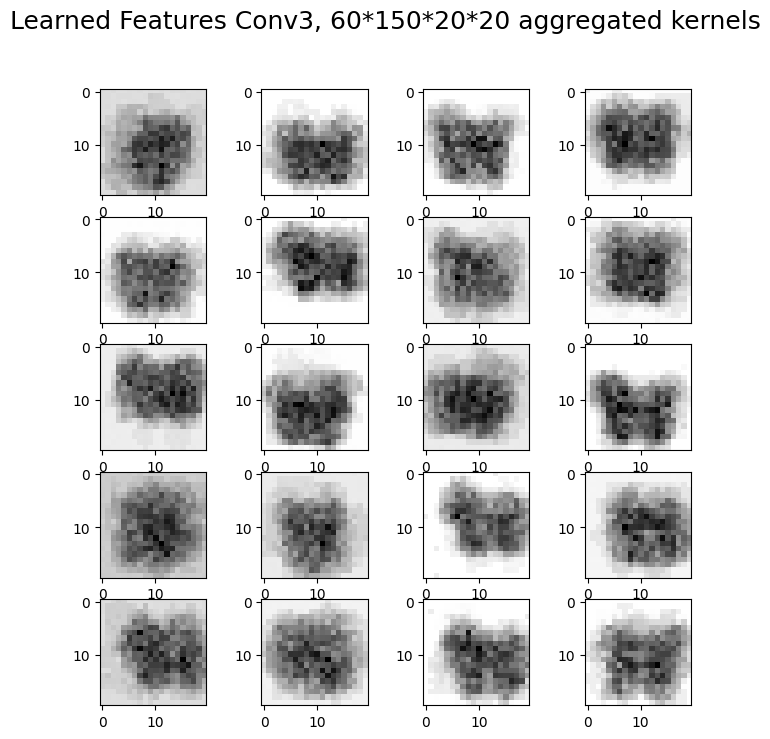

In [33]:
plt.figure(figsize=(8,8))
plt.suptitle("Learned Features Conv3, 60*150*20*20 aggregated kernels",fontsize=18)

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(w3_array[i+30].sum(axis=0),vmin=0,cmap="binary")

plt.savefig("l3_kernels")
plt.show()  

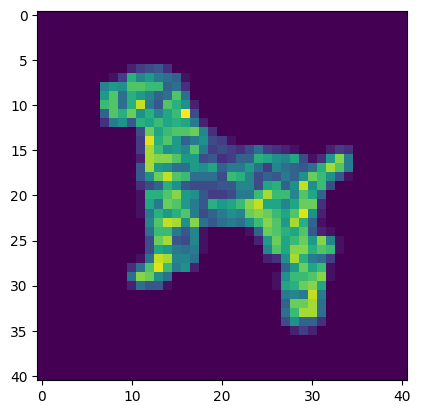

torch.Size([41, 41])


In [85]:
plt.figure()
plt.imshow(global_max_snn_model(data[120][0])[2][-1].sum(axis=0))
plt.show()
print(global_max_snn_model(data[120][0])[2][-1].sum(axis=0).shape)

In [74]:
global_max_snn_model(data[0][0])[0][-1]@global_max_snn_model(data[2][0])[0][-1]


tensor(1.)

In [ ]:
print(np.where(global_max_snn_model(data[0][0])[0][-1])[0])
print(np.where(global_max_snn_model(data[1][0])[0][-1])[0])


[ 0  2 18 19 38 46 51 57 59]
[ 2 16 18 36 52]
